In [10]:
from Bio import AlignIO
import os
from pathlib import Path
import blosum
from Bio.Align import substitution_matrices
import numpy

In [4]:
alignment_path = Path(".") / "Alignments"

In [7]:
alignments = {x.split(".")[0]: AlignIO.read(alignment_path / x, format="clustal") for x in os.listdir("Alignments")}

In [11]:
blosum_matrices = [62, 80, 90]

In [22]:
comparisons = {}

reference_seq = alignments["GABRA1"][0]
for i in blosum_matrices:
    matrix = blosum.BLOSUM(i, -10) # We put in -10 if there is no comparison available
    comparisons[i] = {}
    for seq in alignments["GABRA1"]:
        comparisons[i][seq.id] = [matrix[f"{x}{y}"] for x, y in zip(reference_seq.seq, seq.seq)]

In [91]:
"""
Adapted BLOSUM90 substitution matrix:
Maximal number was substracted from all the values, bringing them to negative values with maximum of 0.
Then the values were reveresed so the least likely change is scored the highest.
Finally, all the diagonal values (synonimous change) were changed to 0.
Scaling everything (except indels) to get values between 0 and 1.
Setting insertion to 2 and deletion to 3.
Setting - => - to -1.
"""
matrix = substitution_matrices.load("BLOSUM90")

matrix = -(matrix - matrix.max())
numpy.fill_diagonal(matrix, 0)
# Temporary setting of the indels to 0
matrix[-1,:] = 0
matrix[:, -1] = 0
# Scaling
matrix = matrix / matrix.max()
# Setting indels
matrix[-1,:] = 2
matrix[:, -1] = 3
matrix[-1, -1] = -1

In [92]:
comparisons = {}
reference_seq = alignments["GABRA1"][0]
for seq in alignments["GABRA1"]:
    comparisons[seq.id] = [matrix[x, y] for x, y in zip(str(reference_seq.seq).replace("-", "*"), str(seq.seq).replace("-", "*"))]

In [66]:
from matplotlib import pyplot
import matplotlib
%matplotlib inline
matplotlib.style.use("ggplot")
matplotlib.rcParams["figure.figsize"] = (30, 1)

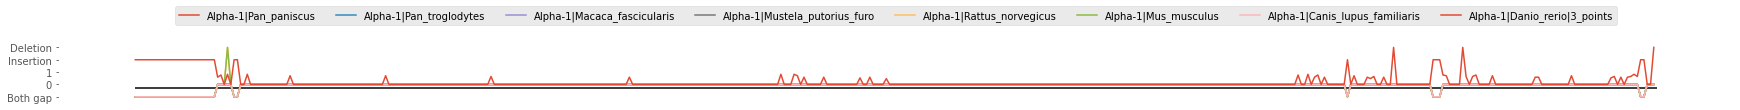

In [95]:
def dict_to_plot(data, ticks=True):
    """
    Function for plotting line-plots from a dictionary containing all the traces to be plotted.
    Argument ticks defines if the x-axis ticks should be plotted.
    """
    fig, ax = pyplot.subplots()
    ax.set_facecolor("white")
    
    for key, data_series in data.items():
        pyplot.plot(data_series, label=key)
    leg = ax.legend(loc="upper center",
                    ncol=len(data.keys()),
                    bbox_to_anchor=(0.5, 1.8))
    pyplot.hlines(-0.3, xmin=0, xmax=len(data[key]), colors="black", linestyles="solid")

    pyplot.yticks(ticks=(-1, 0, 1, 2, 3))
    ax.set_yticklabels(("Both gap", 0, 1, "Insertion", "Deletion"))
    
    pyplot.tick_params(
        axis="x",
        which="both",
        bottom=ticks,
        top=False,
        labelbottom=ticks
    )
dict_to_plot({k: v for k, v in comparisons.items() if not "Homo_sapiens" in k}, ticks=False)